<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/composite_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [32]:

def create_composite_indicator(df):
    # Select relevant features
    features = ['feat_Div_Yield', 'feat_PB', 'feat_PE', 'new_high_new_low', 'nifty_above_dma', 'FIICash', 'DIIcash']

    # Create a copy of the dataframe with only the selected features
    df_features = df[features].copy()

    # Handle missing values (if any)
    df_features = df_features.fillna(df_features.mean())

    # Normalize the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df_features.index)

    # Assign weights to each feature (you may adjust these based on domain knowledge)
    weights = {
        'feat_Div_Yield': 0.10,
        'feat_PB': 0.17,
        'feat_PE': 0.18,
        'new_high_new_low': 0.10,
        'nifty_above_dma': 0.21,
        'FIICash': 0.12,
        'DIIcash': 0.12
        }

    # Calculate the composite indicator
    composite_indicator = sum(df_scaled[feature] * weight for feature, weight in weights.items())

    # Normalize the composite indicator to a 0-100 scale
    min_val = composite_indicator.min()
    max_val = composite_indicator.max()
    normalized_indicator = 100 * (composite_indicator - min_val) / (max_val - min_val)

    return normalized_indicator

# Assuming your dataframe is named 'df'
df = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/.github.io/master/work/ml/data_for_ml.csv')  # Uncomment this line if you're reading from a CSV file

# Create the composite indicator
df['composite_indicator'] = create_composite_indicator(df)

# Interpret the indicator
df['valuation'] = pd.cut(df['composite_indicator'],
                         bins=[0, 30, 70, 100],
                         labels=['Undervalued', 'Fairly Valued', 'Overvalued'])



<ipython-input-33-ee67f120ea16>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


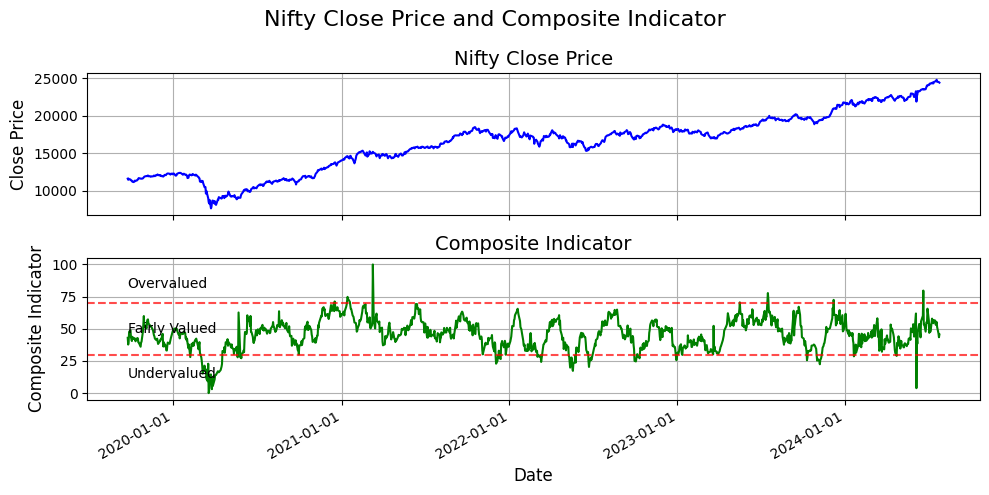

In [33]:


def plot_close_and_indicator(df):
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)
    fig.suptitle('Nifty Close Price and Composite Indicator', fontsize=16)

    # Plot Close price
    ax1.plot(df['Date'], df['Close'], color='blue')
    ax1.set_ylabel('Close Price', fontsize=12)
    ax1.set_title('Nifty Close Price', fontsize=14)
    ax1.grid(True)

    # Plot Composite Indicator
    ax2.plot(df['Date'], df['composite_indicator'], color='green')
    ax2.set_ylabel('Composite Indicator', fontsize=12)
    ax2.set_title('Composite Indicator', fontsize=14)
    ax2.grid(True)

    # Add horizontal lines for valuation levels
    ax2.axhline(y=30, color='r', linestyle='--', alpha=0.7)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7)
    ax2.text(df['Date'].iloc[0], 15, 'Undervalued', verticalalignment='center')
    ax2.text(df['Date'].iloc[0], 50, 'Fairly Valued', verticalalignment='center')
    ax2.text(df['Date'].iloc[0], 85, 'Overvalued', verticalalignment='center')

    # Format x-axis
    plt.xlabel('Date', fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Assuming you have already created the dataframe 'df' with 'Close' and 'composite_indicator' columns
# If you need to read the data again:
# df = pd.read_csv('your_data.csv')
# df['composite_indicator'] = create_composite_indicator(df)  # Make sure you've defined this function

# Call the plotting function
plot_close_and_indicator(df)

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

def optimize_weights_improved(df):
    # Prepare the data
    features = ['feat_Div_Yield', 'feat_PB', 'feat_PE', 'new_high_new_low', 'nifty_above_dma', 'FIICash', 'DIIcash']
    X = df[features]

    # Calculate 6-month forward returns
    df['future_returns'] = df['Close'].pct_change(periods=2).shift(-2)
    y = df['future_returns']

    # Remove rows with NaN values
    valid_indices = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_indices]
    y = y[valid_indices]

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Perform time series cross-validation
    cv_scores = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        cv_scores.append(r2_score(y_test, y_pred))

    # Print cross-validation performance
    print(f"Mean R-squared from cross-validation: {np.mean(cv_scores):.4f}")

    # Fit the model on all data
    rf_model.fit(X_scaled, y)

    # Get feature importances
    importances = rf_model.feature_importances_
    weights = dict(zip(features, importances))

    # Normalize weights to sum to 1
    total = sum(weights.values())
    normalized_weights = {k: v/total for k, v in weights.items()}

    return normalized_weights

# Assuming you have a DataFrame 'df' with all necessary columns
# df = pd.read_csv('your_data.csv')

optimized_weights = optimize_weights_improved(df)

print("\nOptimized weights based on feature importance:")
for feature, weight in optimized_weights.items():
    print(f"{feature}: {weight:.4f}")

# Use these weights to create a new composite indicator
def create_optimized_indicator(df, weights):
    features = list(weights.keys())
    df_features = df[features].copy()

    # Handle missing values
    df_features = df_features.fillna(df_features.mean())

    # Normalize the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df_features.index)

    # Calculate the composite indicator
    composite_indicator = sum(df_scaled[feature] * weight for feature, weight in weights.items())

    # Normalize the composite indicator to a 0-100 scale
    min_val = composite_indicator.min()
    max_val = composite_indicator.max()
    normalized_indicator = 100 * (composite_indicator - min_val) / (max_val - min_val)

    return normalized_indicator

df['optimized_indicator'] = create_optimized_indicator(df, optimized_weights)

print("\nNew composite indicator created with optimized weights.")
print(df[['Date', 'Close', 'optimized_indicator']].tail())

Mean R-squared from cross-validation: -0.4063

Optimized weights based on feature importance:
feat_Div_Yield: 0.1054
feat_PB: 0.1736
feat_PE: 0.1788
new_high_new_low: 0.0987
nifty_above_dma: 0.2078
FIICash: 0.1216
DIIcash: 0.1142

New composite indicator created with optimized weights.
           Date     Close  optimized_indicator
1195 2024-07-18  24800.85            55.186114
1196 2024-07-19  24530.90            51.082698
1197 2024-07-22  24509.25            46.142023
1198 2024-07-23  24479.05            42.821830
1199 2024-07-24  24413.50            44.661798


In [ ]:
Stop

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def optimize_weights(df):
    # Prepare the data
    features = ['feat_Div_Yield', 'feat_PB', 'feat_PE', 'new_high_new_low', 'nifty_above_dma', 'FIICash', 'DIIcash']
    X = df[features]

    # Calculate 1-month forward returns (assuming daily data)
    df['future_returns'] = df['Close'].pct_change(periods=2).shift(-2)
    y = df['future_returns']

    # Remove rows with NaN values
    valid_indices = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_indices]
    y = y[valid_indices]

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Get the coefficients (weights)
    weights = dict(zip(features, model.coef_))

    # Normalize weights to sum to 1
    total = sum(abs(w) for w in weights.values())
    normalized_weights = {k: abs(v)/total for k, v in weights.items()}

    # Print model performance
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Model R-squared on training data: {train_score:.4f}")
    print(f"Model R-squared on test data: {test_score:.4f}")

    return normalized_weights

# Assuming you have a DataFrame 'df' with all necessary columns
# df = pd.read_csv('your_data.csv')

optimized_weights = optimize_weights(df)

print("\nOptimized weights:")
for feature, weight in optimized_weights.items():
    print(f"{feature}: {weight:.4f}")

# Use these weights to create a new composite indicator
def create_optimized_indicator(df, weights):
    features = list(weights.keys())
    df_features = df[features].copy()

    # Handle missing values
    df_features = df_features.fillna(df_features.mean())

    # Normalize the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df_features.index)

    # Calculate the composite indicator
    composite_indicator = sum(df_scaled[feature] * weight for feature, weight in weights.items())

    # Normalize the composite indicator to a 0-100 scale
    min_val = composite_indicator.min()
    max_val = composite_indicator.max()
    normalized_indicator = 100 * (composite_indicator - min_val) / (max_val - min_val)

    return normalized_indicator

df['optimized_indicator'] = create_optimized_indicator(df, optimized_weights)

print("\nNew composite indicator created with optimized weights.")
print(df[['Date', 'Close', 'optimized_indicator']].tail())

Model R-squared on training data: 0.0167
Model R-squared on test data: -0.0123

Optimized weights:
feat_Div_Yield: 0.2563
feat_PB: 0.0137
feat_PE: 0.1466
new_high_new_low: 0.0516
nifty_above_dma: 0.1995
FIICash: 0.2414
DIIcash: 0.0910

New composite indicator created with optimized weights.
           Date     Close  optimized_indicator
1195 2024-07-18  24800.85            47.448790
1196 2024-07-19  24530.90            41.386569
1197 2024-07-22  24509.25            40.488008
1198 2024-07-23  24479.05            30.652848
1199 2024-07-24  24413.50            28.348861
